In [1]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
from pylab import rcParams

plt.style.use('fivethirtyeight')

%matplotlib inline

%config InlineBackend.figure_format = 'svg'

In [2]:
data = pd.read_csv('input/train.csv')

## Предобработка на выбросы датасета вручную

In [3]:
data.loc[data['HouseYear'] == 20052011, 'HouseYear'] = 2008

In [4]:
data.loc[data['HouseYear'] == 4968, 'HouseYear'] = 1968

In [5]:
data.loc[(data['HouseFloor'] > 40) & (data['HouseYear'] < 2000), 'HouseFloor'] = 9

In [6]:
data.loc[data['Rooms'] == 19, 'Rooms'] = 1

## Разделение датасета на учебную и валидационную

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
train, valid = train_test_split(data, test_size=0.21, random_state=100)

## Featuring engeneering

In [9]:
# Создание нового признака large_district
distr_info1 = train['DistrictId'].value_counts().reset_index().\
    rename(columns={'index': 'DistrictId', 'DistrictId': 'large_district'})


In [10]:
# Создание нового признака is_large по разделению районов города на большие и маленькие застройки
distr_info1['is_large'] = (distr_info1['large_district'] > 100).astype(int)

In [11]:
# Создание признака средней цены на основе парметров йд района и кол-ва комнат
price_mean = train['Price'].mean()
price_mean_by_rooms = train.groupby(['Rooms'], as_index=False).agg({'Price': 'mean'}).rename(columns={'Price': 'mean_price_r'})
price_mean_by_distr_rooms = train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price': 'mean'}).\
    rename(columns={'Price': 'mean_price_dr'})

In [12]:
# Функция конвертирования нечисловых признаков в числовые
def ecologi_convert(df):
    df.loc[(df['Ecology_2'] != 'B'), 'Ecology_2'] = 0
    df.loc[(df['Ecology_2'] == 'B'), 'Ecology_2'] = 1
    
    df.loc[(df['Ecology_3'] != 'B'), 'Ecology_3'] = 0
    df.loc[(df['Ecology_3'] == 'B'), 'Ecology_3'] = 1
    return df

In [13]:
# Функция исправления неправлиьных данных признака "HouseYear" на усреденные
def house_year_control(df, source_df):
    df.loc[df['HouseYear'] > 2020, 'HouseYear'] = int(source_df.loc[(source_df['HouseYear'] <= 2020) & 
                                                           (source_df['HouseYear'] >= 1910), 'HouseYear'].mean())
    df.loc[df['HouseYear'] < 1910, 'HouseYear'] = int(source_df.loc[(source_df['HouseYear'] <= 2020) & 
                                                           (source_df['HouseYear'] >= 1910), 'HouseYear'].mean())
    return df

In [14]:
# Функция исправления неправлиьных данных признака "square_control" на усреденные в зависимости от кол-ва комнат
def square_control(df, source_df):
    df.loc[(df['Square'] < 15) & (df['Rooms'] < 2), 'Square'] = source_df.loc[source_df['Rooms'] < 2, 'Square'].median()
    df.loc[(df['Square'] < 15) & (df['Rooms'] == 2), 'Square'] = source_df.loc[source_df['Rooms'] == 2, 'Square'].median()
    df.loc[(df['Square'] < 15) & (df['Rooms'] > 2), 'Square'] = source_df.loc[source_df['Rooms'] > 2, 'Square'].median()
    
    df.loc[(df['Square'] > 95) & (df['Rooms'] < 3), 'Square'] = source_df.loc[source_df['Rooms'] == 2, 'Square'].median()
    
    df.loc[(df['Square'] > 300) & (df['Rooms'] > 0) & (df['Rooms'] < 9), 'Square'] = source_df.loc[
        source_df['Rooms'] > 2, 'Square'].median()
    return df

In [15]:
# Функция исправления неправлиьных данных признака "HouseFloor" на усреденные
def houseFloor_control(df, source_df):
    df.loc[(df['HouseFloor'] > 30) & (df['HouseYear'] < 2010), 'HouseFloor']= int(source_df['HouseFloor'].median())
    df.loc[(df['Floor']) > (df['HouseFloor']), 'HouseFloor']= (df['Floor'] + 1)
#     df.loc[(df['HouseFloor'] > 6), 'HouseFloor'] = 6
    return df

In [16]:
# Функция исправления неправлиьных данных признака "KitchenSquare" на усреденные

def kitchenSquare_control(df):
    df.loc[(df['KitchenSquare'] > df['Square'] * 0.35 ), 'KitchenSquare'] = df['Square'] * 0.22
#     df.loc[df['KitchenSquare'] > 10, 'KitchenSquare']= source_df['KitchenSquare'].median()
    return df

In [17]:
# Функция добавления нового признака "is_large" к датасету и проверка и заполнение пустых значений усредненными
def add_distr_info(df, distr_info1):
    df = pd.merge(df, distr_info1, on='DistrictId', how='left')
    df['is_large'] = df['is_large'].fillna(0)
    df['large_district'] = df['large_district'].fillna(1)
    return df

In [18]:
# Функция добавления нового признаков "mean_price_dr" и "mean_price_r" к датасету и проверка и 
# заполнение пустых значений усредненными
def add_mean_price(df, price_mean_by_distr_rooms, price_mean_by_rooms, price_mean):
    df = pd.merge(df, price_mean_by_distr_rooms, on=['DistrictId', 'Rooms'], how='left')
    df = pd.merge(df, price_mean_by_rooms, on='Rooms', how='left')
    
    df['mean_price_dr'] = df['mean_price_dr'].fillna(df['mean_price_dr'])
    df['mean_price_dr'] = df['mean_price_dr'].fillna(price_mean)
    df['mean_price_r'] = df['mean_price_r'].fillna(price_mean)
    return df

In [19]:
# Функция для запуска всех функций обработки датасета
def prepare_data(df, source_df, distr_info1, price_mean_by_distr_rooms, price_mean_by_rooms, price_mean):
    df = house_year_control(df, source_df)
    df = square_control(df, source_df)
    df = houseFloor_control(df, source_df)
    df = kitchenSquare_control(df)  
    df = add_distr_info(df, distr_info1)
    df = add_mean_price(df, price_mean_by_distr_rooms, price_mean_by_rooms, price_mean)
    df = ecologi_convert(df)
    return df

In [20]:
# Обработка датасета 
train = prepare_data(train, train, distr_info1, price_mean_by_distr_rooms, price_mean_by_rooms, price_mean)

C:\Users\alex\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [21]:
# Обработка датасета 
valid = prepare_data(valid, train, distr_info1, price_mean_by_distr_rooms, price_mean_by_rooms, price_mean)

## Построение графиков зависиостей признаков

In [22]:
# Построим Correlation matrix
X_corr = train.corr()

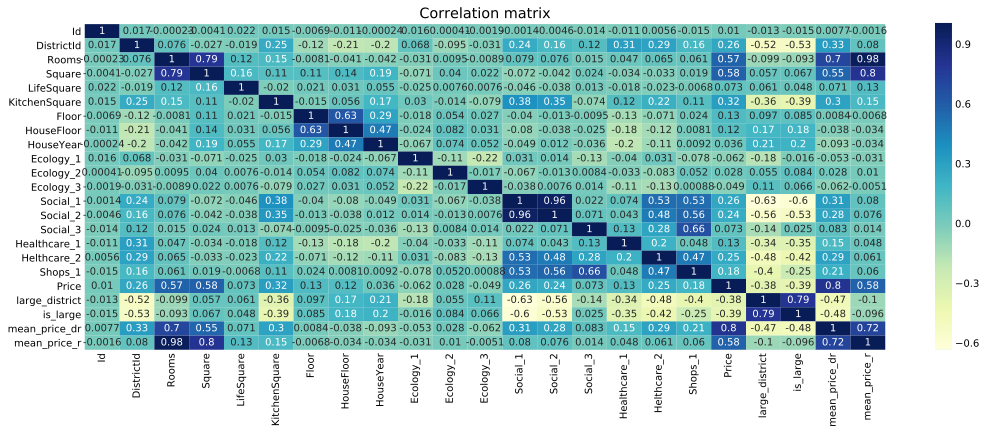

In [23]:
import seaborn as sns

f, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(X_corr, mask=np.zeros_like(X_corr, dtype=np.bool),
            ax=ax, annot=True, cmap="YlGnBu");
plt.title('Correlation matrix');
# sns.heatmap(X_corr, annot=True, cmap="YlGnBu");

# По матрице видно, какие признаки оказывают большее влияние на целевую велечину - Цена на кваритру. 
# На основе этих зависимостей подбираем лучшие признаки для рачсета модели (чем выче числа в троке "Цена на квартиру" -
# тем сильнее они оказывают влияние )

## Model

In [24]:
from sklearn.ensemble import RandomForestRegressor as RF

In [25]:
from sklearn.model_selection import GridSearchCV

### Подбор признаков для модели

In [26]:
feats = ['Rooms', 'Square', 'Floor', 'HouseFloor', 
         'KitchenSquare', 
         'HouseYear', 
         'Ecology_1', 'Ecology_3', 
         'Social_1', 'Social_2', 'Social_3', 
         'Helthcare_2', 
         'Shops_1', 
         'DistrictId', 
         'large_district', 'mean_price_r'] 

# Test model parametrs script

In [48]:
# Подбор лучших коэффициентов модели

parametrs = [{'n_estimators': np.arange(500, 600, 25), 'max_depth': np.arange(16, 19)}]
# parametrs = [{'n_estimators': [400], 'max_depth': [13]}]

clf = GridSearchCV(estimator=RF(random_state=100), param_grid=parametrs, scoring='r2', cv=5)
clf.fit(train.loc[:, feats], train['Price'])

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=100, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': array([500, 525, 550, 575]), 'max_depth': array([16, 17, 18])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

## Построение модели с лучшими коэффициентами

In [49]:
# Смотрим лучшие коэффициенты модели
clf.best_params_

{'max_depth': 16, 'n_estimators': 575}

In [50]:
# Строим окончательную модель на их основе
model = RF(max_depth=clf.best_params_['max_depth'], n_estimators=clf.best_params_['n_estimators'], random_state=100)
model.fit(train.loc[:, feats], train['Price'])
    
pred_train = model.predict(train.loc[:, feats])
pred_valid = model.predict(valid.loc[:, feats])

## Проверка качества модели на r2

In [51]:
from sklearn.metrics import r2_score as r2

In [52]:
# Проверка среднеквадратичной ошибки на учебном датасете
r2_train = r2(train['Price'], pred_train)
r2_train

0.9478964668353935

In [53]:
# Проверка среднеквадратичной ошибки на валидационном датасете
r2_valid = r2(valid['Price'], pred_valid)
r2_valid

0.7402123864972964

# Работа с тестовым датасетом

In [54]:
test = pd.read_csv('input/test.csv')

In [55]:
test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [56]:
# Обработка датасета 
test = prepare_data(test, train, distr_info1, price_mean_by_distr_rooms, price_mean_by_rooms, price_mean)

In [57]:
# Предсказываем цены на тренировочном датасете
test['Price'] = model.predict(test.loc[:, feats])

In [58]:
test['Price'].head()

0    161725.540763
1    233296.039162
2    288575.109172
3    325009.400876
4    146820.393365
Name: Price, dtype: float64

In [59]:
# Записываем в файл результыты предсказания модели
test.loc[:, ['Id', 'Price']].to_csv('input/AlexGreen_test_price.csv', index=False)